##### Imports 

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "white", font="verdana") # font_scale = 1.35)

##### Logging Set-up

In [2]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

##### Pandas Display Settings

In [3]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [4]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [5]:
path_jem = os.path.join(csv_path, "jem_metadata_wFAILURE.csv")
path_ephys = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
path_shiny = os.path.join(csv_path, "Mouse_VISp_ctx_shiny.csv")

In [6]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"]

In [7]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

##### Main

In [39]:
def main():
    global jem, shiny, ephys, merge_sj, merge_all, merge_all_glu, merge_all_gab, rsp_glu, visp_glu, rsp_visp_glu
    jem = read_file(path_jem, fields_jem) #20843 rows
    ephys = read_file(path_ephys, fields_ephys) #8541 rows
    shiny = read_file(path_shiny, fields_shiny) #10674 rows

    jem = filter_df(jem, "status", "SUCCESS") #13325 rows
    jem = filter_date_range(jem, "date") #6335 rows
    
    shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
    shiny = filter_date_range(shiny, "patch.date") #2849 rows

    merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
    merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

    merge_all = drop_nans(merge_all, drop_nans_list)
    merge_all = drop_cols(merge_all, drop_cols_list)
    merge_all = create_container_col(merge_all, "rigOperator")
    merge_all.set_index("date", inplace=True)
    
    merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                      pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                      pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                      pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                      pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                      pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                      pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                      pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))
    
    merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
    merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

    rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
    visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])
    rsp_visp_glu = pd.concat([rsp_glu, visp_glu])

In [40]:
if __name__ == "__main__":
    main()

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INF

##### HeatMap

In [41]:
rsp_glu = rsp_glu[rsp_glu["f_i_curve_slope"] < 0.7]
rsp_glu = rsp_glu[rsp_glu["ri"] < 600]
rsp_glu = rsp_glu[rsp_glu["upstroke_downstroke_ratio_long_square"] < 7]
rsp_glu = rsp_glu[rsp_glu["latency"] < 0.15]
rsp_glu = rsp_glu[rsp_glu["sag"] < 0.40]
rsp_glu = rsp_glu[rsp_glu["vrest"] < -50]
rsp_glu = rsp_glu[rsp_glu["tau"] < 40]

In [42]:
visp_glu = visp_glu[visp_glu["f_i_curve_slope"] < 0.7]
visp_glu = visp_glu[visp_glu["ri"] < 600]
visp_glu = visp_glu[visp_glu["upstroke_downstroke_ratio_long_square"] < 7]
visp_glu = visp_glu[visp_glu["latency"] < 0.15]
visp_glu = visp_glu[visp_glu["sag"] < 0.40]
visp_glu = visp_glu[visp_glu["vrest"] < -50]
visp_glu = visp_glu[visp_glu["tau"] < 40]

In [50]:
rsp_glu.reset_index(inplace=True)
visp_glu.reset_index(inplace=True)
rsp_visp_glu.reset_index(inplace=True)
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

In [51]:
sub5_list = ["L2 IT RSP-ACA", "L5 NP CTX", "L5 ET CTX"]

In [52]:
rv_df = rsp_visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]

In [53]:
rv_df

,subclass_label,region,vrest,ri,sag,tau,upstroke_downstroke_ratio_long_square,latency,f_i_curve_slope
0,L6 CT CTX,RSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L5 ET CTX,RSP,-70.223257,136.874914,0.155849,14.594543,3.478434,0.04520,0.180000
2,L6 CT CTX,RSP,-75.316888,120.218694,0.125441,10.655021,2.352148,0.02718,0.154206
3,L6 CT CTX,RSP,-69.322589,85.781246,0.071316,7.393267,2.357199,0.03606,0.015000
4,L5 NP CTX,RSP,-80.120851,204.507247,0.086246,15.850263,3.666870,0.05186,0.360000
...,...,...,...,...,...,...,...,...,...
1333,L6 Car3,VISp,-71.172249,205.949500,0.105195,19.525528,3.655178,0.02760,0.016822
1334,L6 Car3,VISp,-75.442434,157.937467,0.028307,21.828857,3.581690,0.05750,0.087750
1335,L6 Car3,VISp,-83.142639,134.187505,0.079507,22.286570,3.597191,0.05322,0.170000
1336,L6 Car3,VISp,-72.435637,88.071622,0.002853,13.815666,3.243047,0.13772,0.170000


In [54]:
rv_heatmap_df = create_cond_df(rv_df, "subclass_label", sub5_list)

INFO:functions.temp_funcs:Created a conditional dataframe based on subclass_label containing ['L2 IT RSP-ACA', 'L5 NP CTX', 'L5 ET CTX']


In [55]:
rv_heatmap_df

,subclass_label,region,vrest,ri,sag,tau,upstroke_downstroke_ratio_long_square,latency,f_i_curve_slope
1,L5 ET CTX,RSP,-70.223257,136.874914,0.155849,14.594543,3.478434,0.04520,0.180000
4,L5 NP CTX,RSP,-80.120851,204.507247,0.086246,15.850263,3.666870,0.05186,0.360000
5,L2 IT RSP-ACA,RSP,-65.282120,59.750024,0.148347,13.020941,3.711103,0.03164,0.149533
7,L5 ET CTX,RSP,-88.126678,36.550403,0.159878,9.964491,2.951999,0.04614,0.024934
8,L5 ET CTX,RSP,-70.609880,96.781231,0.159202,18.911453,3.865665,0.05422,0.100000
...,...,...,...,...,...,...,...,...,...
1321,L5 ET CTX,VISp,-64.922798,102.187499,0.168252,15.428466,4.244269,0.04754,0.125000
1322,L5 ET CTX,VISp,-70.940084,100.156248,0.201257,15.305078,3.545299,0.04600,0.180000
1323,L5 ET CTX,VISp,-67.124172,105.656207,0.170631,17.216180,3.169918,0.05450,0.255000
1327,L5 ET CTX,VISp,-73.793427,124.812543,0.245268,16.916544,3.653899,0.04712,0.160000


In [14]:
r_df = rsp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]
r_df = r_df.groupby(["subclass_label", "region"]).mean().reset_index()

v_df = visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]
v_df = v_df.groupby(["subclass_label", "region"]).mean().reset_index()

In [15]:
heatmap_df = pd.merge(left=r_df, right=v_df, on="subclass_label")

In [16]:
heatmap_df = create_cond_df(heatmap_df, "subclass_label", sub5_list)

INFO:functions.temp_funcs:Created a conditional dataframe based on subclass_label containing ['L2 IT RSP-ACA', 'L5 NP CTX', 'L5 ET CTX']


In [17]:
heatmap_df["vrest"] = ((heatmap_df["vrest_x"] - heatmap_df["vrest_y"]) / heatmap_df["vrest_y"].abs()) * 100 #new - old/old  = r - v/v
heatmap_df["ri"] = ((heatmap_df["ri_x"] - heatmap_df["ri_y"]) / heatmap_df["ri_y"]) * 100
heatmap_df["sag"] = ((heatmap_df["sag_x"] - heatmap_df["sag_y"]) / heatmap_df["sag_y"]) * 100
heatmap_df["tau"] = ((heatmap_df["tau_x"] - heatmap_df["tau_y"]) / heatmap_df["tau_y"]) * 100
heatmap_df["upstroke_downstroke_ratio_long_square"] = ((heatmap_df["upstroke_downstroke_ratio_long_square_x"] - heatmap_df["upstroke_downstroke_ratio_long_square_y"]) / heatmap_df["upstroke_downstroke_ratio_long_square_y"]) * 100
heatmap_df["latency"] = ((heatmap_df["latency_x"] - heatmap_df["latency_y"]) / heatmap_df["latency_y"]) * 100
heatmap_df["f_i_curve_slope"] = ((heatmap_df["f_i_curve_slope_x"] - heatmap_df["f_i_curve_slope_y"]) / heatmap_df["f_i_curve_slope_y"]) * 100
heatmap_df

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,subclass_label,region_x,vrest_x,ri_x,sag_x,tau_x,upstroke_downstroke_ratio_long_square_x,latency_x,f_i_curve_slope_x,region_y,vrest_y,ri_y,sag_y,tau_y,upstroke_downstroke_ratio_long_square_y,latency_y,f_i_curve_slope_y,vrest,ri,sag,tau,upstroke_downstroke_ratio_long_square,latency,f_i_curve_slope
0,L2 IT RSP-ACA,RSP,-76.811338,104.348811,0.035903,10.586263,2.925136,0.046587,0.198403,VISp,-76.773133,98.861731,0.024403,12.694613,4.122600,0.064600,0.161421,-0.049764,5.550257,47.123079,-16.608223,-29.046333,-27.883680,22.910700
4,L5 ET CTX,RSP,-69.061524,111.394068,0.166532,15.468225,3.597249,0.046611,0.155662,VISp,-67.618672,118.445908,0.172814,17.198791,3.597866,0.046581,0.164323,-2.133807,-5.953638,-3.635655,-10.062141,-0.017139,0.064712,-5.270761
6,L5 NP CTX,RSP,-73.900963,243.984663,0.069398,18.792059,3.797228,0.038696,0.353778,VISp,-66.517502,270.316173,0.153057,22.180426,4.213208,0.026652,0.273864,-11.100027,-9.741004,-54.659084,-15.276384,-9.873225,45.190701,29.180182


In [18]:
heatmap_df.drop(columns=["vrest_x", "vrest_y",
                    "ri_x", "ri_y", 
                    "sag_x", "sag_y", 
                    "tau_x", "tau_y",
                    "upstroke_downstroke_ratio_long_square_x", "upstroke_downstroke_ratio_long_square_y",
                    "latency_x", "latency_y",
                    "f_i_curve_slope_x", "f_i_curve_slope_y",
                    "region_x", "region_y"], inplace=True)

heatmap_df.rename(columns={"vrest": "Vm(mV)", 
                      "ri": "Input Resistance(MΩ)",
                      "sag" : "Sag Fraction",
                      "tau": "τ(s)",
                      "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke",
                      "latency" : "Latency",
                      "f_i_curve_slope" : "F-I Curve"}, inplace=True)

heatmap_df = heatmap_df.melt(id_vars=["subclass_label"],
                             value_vars=["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)",
                                         "LS AP up/downstoke", "Latency", "F-I Curve"],
                             var_name="ephys_features", value_name="%change from VISp")

heatmap_df = pd.pivot_table(heatmap_df, values='%change from VISp', index=["ephys_features"], columns="subclass_label")
heatmap_df

subclass_label,L2 IT RSP-ACA,L5 ET CTX,L5 NP CTX
ephys_features,,,
F-I Curve,22.910700,-5.270761,29.180182
Input Resistance(MΩ),5.550257,-5.953638,-9.741004
LS AP up/downstoke,-29.046333,-0.017139,-9.873225
Latency,-27.883680,0.064712,45.190701
Sag Fraction,47.123079,-3.635655,-54.659084
Vm(mV),-0.049764,-2.133807,-11.100027
τ(s),-16.608223,-10.062141,-15.276384


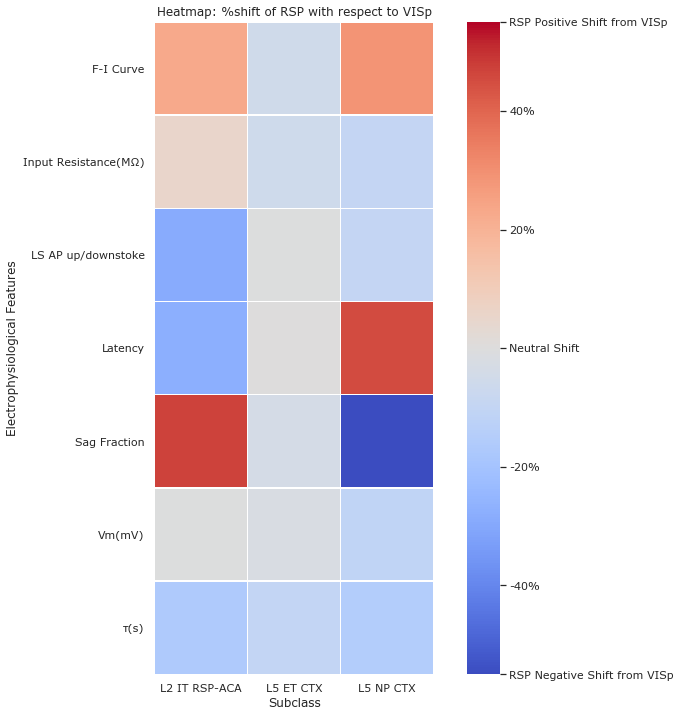

In [37]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data=heatmap_df,
            vmin=-55, 
            vmax=55,
            cmap="coolwarm",
            center=0,
            #robust=True,
            #annot=True,
            fmt="0.2g",
            linewidths=0.5,
            square=True,
            cbar=True,
            cbar_kws={"shrink": 1}) #"label": "RSP %change from VISp", 

plt.title("Heatmap: %shift of RSP with respect to VISp")
plt.xlabel("Subclass")
plt.ylabel("Electrophysiological Features")

#Seaborn heatmap cutoffs, so to fix it use the code below
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-55, -40, -20, 0, 20, 40, 55])
cbar.set_ticklabels(["RSP Negative Shift from VISp",
                     "-40%",
                     "-20%", 
                     "Neutral Shift", 
                     "20%", 
                     "40%", 
                     "RSP Positive Shift from VISp"])

plt.savefig(plot_path + "heatmap.jpeg", bbox_inches="tight")